In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior
from mxnet.gluon.contrib import nn as nn_contrib
from mxnet.gluon import nn
ctx = mx.gpu()

### Predict classes
- channel `i*(num_class+1)` store the scores for this box contains only background
- channel `i*(num_class+1)+1+j` store the scores for this box contains an object from the *j*-th class

In [2]:
def class_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

### Predict anchor boxes
- $t_x = (Y_x - b_x) / b_{width}$
- $t_y = (Y_y - b_y) / b_{height}$
- $t_{width} = (Y_{width} - b_{width}) / b_{width}$
- $t_{height} = (Y_{height} - b_{height}) / b_{height}$

In [3]:
def box_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

### Manage preditions from multiple layers

In [4]:
def flatten_prediction(pred):
    return nd.flatten(nd.transpose(pred, axes=(0, 2, 3, 1)))

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

### Down-sample features

In [5]:
def dp_layer(nfilters, stride, expension_constant):
    out = nn.HybridSequential()
    out.add(nn.Conv2D(nfilters, 3, strides=stride, padding=1, groups=nfilters, use_bias=False))
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    out.add(nn.Activation('relu'))
    out.add(nn.Conv2D(nfilters*expension_constant, 1, strides=1, padding=0, use_bias=False))
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    out.add(nn.Activation('relu'))
    return out

### Scale units

In [6]:
global alpha
alpha = 0.25
num_filters = int(32*alpha)

### Body network

In [7]:
from mxnet import gluon
def s16():
    out = nn.HybridSequential()
    # conv_0 layer
    out.add(nn.Conv2D(num_filters, 3, strides=2, padding=1, use_bias=False))
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    out.add(nn.Activation('relu'))
    # conv_1 layer
    out.add(dp_layer(num_filters, 1, 2))
    # conv_2 layer
    out.add(dp_layer(num_filters*2, 2, 2))
    # conv_3 layer
    out.add(dp_layer(num_filters*4, 1, 1))
    out.add(nn.Conv2D(num_filters*4, 3, strides=2, padding=1, groups=num_filters*4, use_bias=False))
    out.load_parameters("weights/mobilenet_0_25_s16_dist.params", ctx=ctx)
    out.hybridize()
    return out

def s32():
    out = nn.HybridSequential()
    # from last layer
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    out.add(nn.Activation('relu'))
    out.add(nn.Conv2D(num_filters*8, 1, strides=1, padding=0, use_bias=False))
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    out.add(nn.Activation('relu'))
    # conv_4_layer
    out.add(dp_layer(num_filters*8, 1, 1))
    out.add(nn.Conv2D(num_filters*8, 3, strides=2, padding=1, groups=num_filters*8, use_bias=False))
    out.load_parameters("weights/mobilenet_0_25_s32_dist.params", ctx=ctx)
    out.hybridize()
    return out

def b1():
    out = nn.HybridSequential()
    # from last layer
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    out.add(nn.Activation('relu'))
    out.add(nn.Conv2D(num_filters*16, 1, strides=1, padding=0, use_bias=False))
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    out.add(nn.Activation('relu'))
    # conv_6_layer
    out.add(dp_layer(num_filters*16, 1, 1))
    out.add(nn.Conv2D(num_filters*16, 3, strides=2, padding=1, groups=num_filters*16, use_bias=False))
    out.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)
    out.hybridize()
    return out

def b2():
    out = nn.HybridSequential()
    # from last layer
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    out.add(nn.Activation('relu'))
    out.add(nn.Conv2D(num_filters*16, 1, strides=1, padding=0, use_bias=False))
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    out.add(nn.Activation('relu'))
    # conv_7_layer
    out.add(dp_layer(num_filters*16, 1, 1))
    out.add(nn.Conv2D(num_filters*16, 3, strides=2, padding=1, groups=num_filters*16, use_bias=False))
    out.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)
    out.hybridize()
    return out

def b3():
    out = nn.HybridSequential()
    # from last layer
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    out.add(nn.Activation('relu'))
    out.add(nn.Conv2D(num_filters*16, 1, strides=1, padding=0, use_bias=False))
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    out.add(nn.Activation('relu'))
    # conv_7_layer
    out.add(dp_layer(num_filters*16, 1, 1))
    out.add(nn.Conv2D(num_filters*16, 3, strides=2, padding=1, groups=num_filters*16, use_bias=False))
    out.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)
    out.hybridize()
    return out

def b4():
    out = nn.HybridSequential()
    # from last layer
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    out.add(nn.Activation('relu'))
    out.add(nn.Conv2D(num_filters*16, 1, strides=1, padding=0, use_bias=False))
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    out.add(nn.Activation('relu'))
    # conv_7_layer
    out.add(dp_layer(num_filters*16, 1, 1))
    out.add(nn.Conv2D(num_filters*16, 3, strides=2, padding=1, groups=num_filters*16, use_bias=False))
    out.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)
    out.hybridize()
    return out

### Create an SSD model

In [8]:
def ssd_model(num_anchors, num_classes):
    class_preds = nn.Sequential()
    box_preds = nn.Sequential()
    
    for scale in range(6):
        class_preds.add(class_predictor(num_anchors, num_classes))
        box_preds.add(box_predictor(num_anchors))
    
    class_preds.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)
    box_preds.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)
    return s16(), s32(), b1(), b2(), b3(), b4(), class_preds, box_preds

### Forward

In [9]:
def ssd_forward(x, s16, s32, b1, b2, b3, b4, class_preds, box_preds, sizes, ratios):
    default_anchors = []
    predicted_boxes = []  
    predicted_classes = []

    x = s16(x)
    _, _, ho, wo = x.shape
    for w in range(1,3):
        for h in range(1,6):
            patch = x[:,:,(h-1)*(wo/4):((wo/4)+(wo/4)*h),(w-1)*(wo/2):w*(wo/2)]
            priors = MultiBoxPrior(patch, sizes=sizes[0], ratios=ratios[0])*(wo/2)
            priors[:,:,[0,2]] = (priors[:,:,[0,2]]+(w-1)*(wo/2))/wo
            priors[:,:,[1,3]] = (priors[:,:,[1,3]]+(h-1)*(wo/4))/ho
            default_anchors.append(priors)
            predicted_boxes.append(flatten_prediction(box_preds[0](patch)))
            predicted_classes.append(flatten_prediction(class_preds[0](patch)))
    
    x = s32(x)
    _, _, ho, wo = x.shape
    for w in range(1,3):
        for h in range(1,6):
            patch = x[:,:,(h-1)*(wo/4):((wo/4)+(wo/4)*h),(w-1)*(wo/2):w*(wo/2)]
            priors = MultiBoxPrior(patch, sizes=sizes[0], ratios=ratios[0])*(wo/2)
            priors[:,:,[0,2]] = (priors[:,:,[0,2]]+(w-1)*(wo/2))/wo
            priors[:,:,[1,3]] = (priors[:,:,[1,3]]+(h-1)*(wo/4))/ho
            default_anchors.append(priors)
            predicted_boxes.append(flatten_prediction(box_preds[1](patch)))
            predicted_classes.append(flatten_prediction(class_preds[1](patch)))
    
    x = b1(x)
    _, _, ho, wo = x.shape
    for w in range(1,3):
        for h in range(1,6):
            patch = x[:,:,(h-1)*(wo/4):((wo/4)+(wo/4)*h),(w-1)*(wo/2):w*(wo/2)]
            priors = MultiBoxPrior(patch, sizes=sizes[0], ratios=ratios[0])*(wo/2)
            priors[:,:,[0,2]] = (priors[:,:,[0,2]]+(w-1)*(wo/2))/wo
            priors[:,:,[1,3]] = (priors[:,:,[1,3]]+(h-1)*(wo/4))/ho
            default_anchors.append(priors)
            predicted_boxes.append(flatten_prediction(box_preds[2](patch)))
            predicted_classes.append(flatten_prediction(class_preds[2](patch)))
    
    x = b2(x)
    _, _, ho, wo = x.shape
    for w in range(1,3):
        for h in range(1,6):
            patch = x[:,:,(h-1)*(wo/4):((wo/4)+(wo/4)*h),(w-1)*(wo/2):w*(wo/2)]
            priors = MultiBoxPrior(patch, sizes=sizes[0], ratios=ratios[0])*(wo/2)
            priors[:,:,[0,2]] = (priors[:,:,[0,2]]+(w-1)*(wo/2))/wo
            priors[:,:,[1,3]] = (priors[:,:,[1,3]]+(h-1)*(wo/4))/ho
            default_anchors.append(priors)
            predicted_boxes.append(flatten_prediction(box_preds[3](patch)))
            predicted_classes.append(flatten_prediction(class_preds[3](patch)))
    
    x = b3(x)
    _, _, ho, wo = x.shape
    for w in range(1,3):
        for h in range(1,6):
            patch = x[:,:,(h-1)*(wo/4):((wo/4)+(wo/4)*h),(w-1)*(wo/2):w*(wo/2)]
            priors = MultiBoxPrior(patch, sizes=sizes[0], ratios=ratios[0])*(wo/2)
            priors[:,:,[0,2]] = (priors[:,:,[0,2]]+(w-1)*(wo/2))/wo
            priors[:,:,[1,3]] = (priors[:,:,[1,3]]+(h-1)*(wo/4))/ho
            default_anchors.append(priors)
            predicted_boxes.append(flatten_prediction(box_preds[4](patch)))
            predicted_classes.append(flatten_prediction(class_preds[4](patch)))

    x = b4(x)
    _, _, ho, wo = x.shape
    for w in range(1,3):
        for h in range(1,6):
            patch = x[:,:,(h-1)*(wo/4):((wo/4)+(wo/4)*h),(w-1)*(wo/2):w*(wo/2)]
            priors = MultiBoxPrior(patch, sizes=sizes[0], ratios=ratios[0])*(wo/2)
            priors[:,:,[0,2]] = (priors[:,:,[0,2]]+(w-1)*(wo/2))/wo
            priors[:,:,[1,3]] = (priors[:,:,[1,3]]+(h-1)*(wo/4))/ho
            default_anchors.append(priors)
            predicted_boxes.append(flatten_prediction(box_preds[5](patch)))
            predicted_classes.append(flatten_prediction(class_preds[5](patch)))
    
    return default_anchors, predicted_classes, predicted_boxes

### Put all things together

In [10]:
from mxnet import gluon
class SSD(gluon.Block):
    def __init__(self, num_classes, **kwargs):
        super(SSD, self).__init__(**kwargs)
        self.anchor_sizes = [[0.04, 0.1],[0.1,0.26],[0.26,0.42],[0.42,0.58],[0.58,0.74],[0.74,0.9],[0.9,1.06]]
        self.anchor_ratios = [[1, 2, .5]] * 6
        self.num_classes = num_classes

        with self.name_scope():
            self.s16, self.s32, self.b1, self.b2, self.b3, self.b4, self.class_preds, self.box_preds = ssd_model(4, num_classes)
            
    def forward(self, x):
        default_anchors, predicted_classes, predicted_boxes = ssd_forward(x, self.s16, self.s32, self.b1, self.b2, self.b3, self.b4,
            self.class_preds, self.box_preds, self.anchor_sizes, self.anchor_ratios)
        anchors = concat_predictions(default_anchors)
        box_preds = concat_predictions(predicted_boxes)
        class_preds = concat_predictions(predicted_classes)
        class_preds = nd.reshape(class_preds, shape=(0, -1, self.num_classes + 1))
        
        return anchors, class_preds, box_preds

### Outputs of SSD

In [11]:
net = SSD(2)
#net.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)
net.load_parameters("process/ssd_v1_alpha2_dist_349.params",ctx=ctx)
x = nd.zeros((1, 3, 1920, 1280),ctx=ctx)
default_anchors, class_predictions, box_predictions = net(x)
print('Outputs:', 'anchors', default_anchors.shape, 'class prediction', class_predictions.shape, 'box prediction', box_predictions.shape)

('Outputs:', 'anchors', (1L, 340960L, 4L), 'class prediction', (1L, 340960L, 3L), 'box prediction', (1L, 1363840L))


### Load dataset

In [12]:
from source.NACDDetection import NACDDetection

all_dataset = NACDDetection(splits=[('NACD', 'all')])

print('All images:', len(all_dataset))

('All images:', 462)


In [13]:
from gluoncv.data.transforms import presets
from gluoncv import utils
from mxnet import nd
from matplotlib import pyplot as plt
from gluoncv.utils import viz

In [14]:
from source import NACDTransform
width, height = 1280, 1920
all_transform = presets.ssd.SSDDefaultValTransform(width, height)

In [15]:
all_image, all_label = all_dataset[0]
bboxes = all_label[:, :4]
cids = all_label[:, 4:5]
print('image:', all_image.shape)
print('bboxes:', bboxes.shape, 'class ids:', cids.shape)

('image:', (3000L, 1992L, 3L))
('bboxes:', (46, 4), 'class ids:', (46, 1))


In [16]:
all_image2, all_label2 = all_transform(all_image, all_label)
print('tensor shape:', all_image2.shape)

('tensor shape:', (3L, 1920L, 1280L))


In [17]:
from gluoncv.data.batchify import Tuple, Stack, Pad
from mxnet.gluon.data import DataLoader

batch_size = 4
num_workers = 4

batchify_fn = Tuple(Stack(), Pad(pad_val=-1))
all_loader = DataLoader(all_dataset.transform(all_transform), batch_size, shuffle=False,
                        batchify_fn=batchify_fn, last_batch='keep', num_workers=num_workers)

for ib, batch in enumerate(all_loader):
    if ib > 3:
        break
    print('data:', batch[0].shape, 'label:', batch[1].shape)

('data:', (4L, 3L, 1920L, 1280L), 'label:', (4L, 46L, 6L))
('data:', (4L, 3L, 1920L, 1280L), 'label:', (4L, 49L, 6L))
('data:', (4L, 3L, 1920L, 1280L), 'label:', (4L, 44L, 6L))
('data:', (4L, 3L, 1920L, 1280L), 'label:', (4L, 42L, 6L))


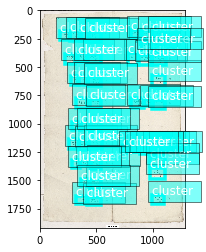

In [18]:
all_image2 = all_image2.transpose((1, 2, 0)) * nd.array((0.229, 0.224, 0.225)) + nd.array((0.485, 0.456, 0.406))
all_image2 = (all_image2 * 255).clip(0, 255)
ax = viz.plot_bbox(all_image2.asnumpy(), all_label2[:, :4],
                   labels=all_label2[:, 4:5],
                   class_names=all_dataset.classes)
plt.show()

## Test

### Prepare the test data

In [19]:
all_image, all_label = all_dataset[2]
all_image2, all_label2 = all_transform(all_image, all_label)
all_image2 = nd.expand_dims(all_image2,0)
print('tensor shape:', all_image2.shape)

('tensor shape:', (1L, 3L, 1920L, 1280L))


### Network inference

In [20]:
anchors, cls_preds, box_preds = net(all_image2.as_in_context(ctx))

### Convert predictions to real object detection results

In [21]:
from mxnet.contrib.ndarray import MultiBoxDetection
cls_probs = nd.SoftmaxActivation(nd.transpose(cls_preds, (0, 2, 1)), mode='channel')
output = MultiBoxDetection(cls_prob=cls_probs, loc_pred=box_preds, anchor=anchors, force_suppress=True, clip=True, nms_topk=250)

### Display results

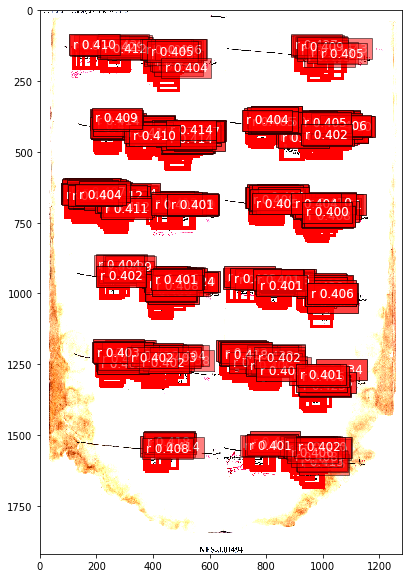

In [23]:
class_names = ('cluster')
def display(img, out, thresh=0.5):
    import random
    import matplotlib as mpl
    import numpy as np
    mpl.rcParams['figure.figsize'] = (10,10)
    img = img.asnumpy()
    img = np.transpose(img,(2,3,1,0))
    img = np.squeeze(img)
    plt.clf()
    plt.imshow(img)
    for det in out:
        cid = int(det[0])
        if cid == 0:
            continue
        score = det[1]
        if score < thresh:
            continue
        scales = [img.shape[1], img.shape[0]] * 2
        xmin, ymin, xmax, ymax = [int(p * s) for p, s in zip(det[2:6].tolist(), scales)]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False,
                             edgecolor='red', linewidth=3)
        plt.gca().add_patch(rect)
        text = class_names[cid]
        plt.gca().text(xmin, ymin-2, '{:s} {:.3f}'.format(text, score),
                       bbox=dict(facecolor='red', alpha=0.5),
                       fontsize=12, color='white')

display(all_image2, output[0].asnumpy(), thresh=0.4)